### Create the line Injection with random...
- position angle (0 to 180)
- velocity width
- length
- Gaussian smooth physical width
- Peak Brightness

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import numpy as np
import pickle 
from cube_fil_finder.util import moments
import random
import astropy.units as u
from cube_fil_finder.util import cube_util
from astropy.io import fits

from fil_finder import FilFinder2D, Filament2D
from fil_finder.tests.testing_utils import generate_filament_model
import mask_obj_node as maskNode
from cube_fil_finder.structs import util as struct_util
from cube_fil_finder.util import moments
from cube_fil_finder.util import tree_dict_util 
from cube_fil_finder.structs import mask_obj_node_tree as maskTree

In [4]:
testslice_ = np.load('/Volumes/Seagate_Backup/Research/Gal_filament/Data/injection_slice.npz')
testdata = testslice_['data']
testvch = testslice_['vchannel']

In [5]:
testdata.shape

(200, 300, 500)

In [5]:
test = testdata[100:150]

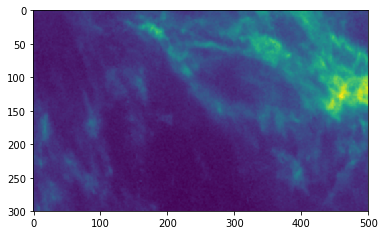

In [7]:
imshow(test[0])

In [24]:
pnarrow_header = fits.getheader('/Volumes/Seagate_Backup/Research/Gal_filament/Data/Perseus/Perseus_Larger/Perseus_large_narrow/Perseus_large_narrow.fits')
pnarrow_header['BUNIT'] = 'K'

In [25]:
def divide_to_quadrant(background):
    """
    divide the total area to 4
    
    Returns:
    coordinates of quadrants
    """
    vlim, ylim, xlim = background.shape
    first = np.array([0,xlim/2, 0,ylim/2])
    second = np.array([0,xlim/2, ylim/2, ylim])
    third = np.array([xlim/2, xlim, 0, ylim/2])
    fourth = np.array([xlim/2, xlim, ylim/2, ylim])
    
    return first, second, third, fourth
    
def generate_fakefils():
    """
    Generate a fake filament
    """
    intensity = 100
    #intensity = np.random.uniform(3,8) * 3
    fangle = np.random.rand() * np.pi/2 ## random angle
    flength = np.random.randint(40,80) ## purely observational
    fwidth = 8
    #fwidth = np.random.randint(3,15) ## ranges of filament intensity
    fakefil = generate_filament_model(return_hdu=False, pad_size=30, shape=flength, theta=fangle, width=fwidth, background=0)[0]
    fakefil = fakefil * intensity
    #fakefil = ski.filters.gaussian(fakefil) * intensity
    return fakefil 

def inject_single_filament(background, nfil=1):
    """
    Inject filament
    """
    back = background.copy()
    vlim, ylim, xlim = background.shape
    if ylim > xlim:
        shortlim = xlim
    else:
        shortlim = ylim
    
    currentv = 0
    filament_coords = []
    
    while currentv < vlim:

        tree_length = np.random.randint(2,10)
        fake_filament = generate_fakefils()
        ly, lx = fake_filament.shape ## purposefully same size
        
        
        ystart= np.random.randint(0,ylim-ly-1,1) 
        xstart = np.random.randint(0,xlim-lx-1,1) 
    
        coordinates = [ystart, ystart+ly, xstart, xstart+lx]
        filament_coords.append(coordinates)
        back[currentv:currentv+tree_length,ystart:ystart+ly, xstart:xstart+lx] += fake_filament
        currentv += tree_length
        print (currentv)
    
    return back, filament_coords

def inject_multifils(background, nfils=2):
    """
    Inject multiple filaments
    """
    back = background.copy()
    vlim, ylim, xlim = background.shape
    

    filament_coords = np.zeros((vlim, nfils*4))
    currentv = 0
    
    while currentv < vlim:
        tree_length = np.random.randint(2,10)
        choices = random.sample(range(4), nfils)
        quadrants = divide_to_quadrant(background)
        ranges = [quadrants[k] for k in choices]

        for i in range(nfils):
            xlower, xupper, ylower, yupper = ranges[i]
            fake_filament = generate_fakefils()
            ly, lx = fake_filament.shape
            #print (ylower, yupper, ly)
            y0 = np.random.randint(ylower,yupper-ly-10)
            x0 = np.random.randint(xlower,xupper-lx-10)
            coords = [y0, y0+ly, x0, x0+lx]
            #print (coords)
            #print (currentv, currentv+tree_length)
            
            filament_coords[currentv:currentv+tree_length, 4*i:4*(i+1)] = coords
            back[currentv:currentv+tree_length,y0:y0+ly, x0:x0+lx] += fake_filament
            
        currentv += tree_length
        print (currentv)
        
    return back, filament_coords
    

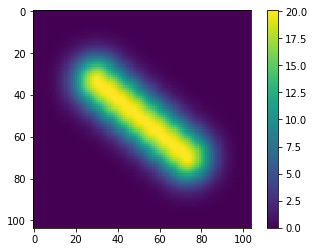

In [18]:
imshow(generate_fakefils())
plt.colorbar()

In [26]:
bright, bright_coord =inject_multifils(test, nfils=2)

9
14
21
25
28
31
33
38
44
51


In [20]:
norm, norm_coord =inject_multifils(test, nfils=2)

8
17
24
27
36
39
46
51


Text(0.5,1,'Filament injected into Raw Test Data at v=10')

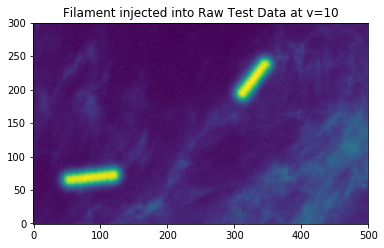

In [27]:
imshow(bright[10], origin='lower')
plt.title('Filament injected into Raw Test Data at v=10')

In [31]:
def construct_filaments(vslice, header, v_channel):
    """
    Find a filamentary structure at a given velocity slice.
    
    Returns:
    node of masked objects (for the purpose of checking overlaps)
    """
    header['BUNIT'] = 'K' # to be read by astropy.units
    scale_width = 0.1 * u.pc # empirical 
    filament = FilFinder2D(vslice, header=header, distance=100.*u.pc, beamwidth=10.*u.arcmin)
    filament.preprocess_image(flatten_percent=95)
    filament_masks, corners = filament.create_mask(smooth_size = scale_width/2, adapt_thresh=scale_width*2, 
                         size_thresh= 8*(scale_width*2)**2, border_masking=False, output_mask_objs=True)
    
    nmasks = len(filament_masks)
    
    node_dict = {}
    if filament_masks is None:
        pass
    else:
        for i in range(nmasks):
            mask_node = maskNode.MaskObjNode(filament_masks[i], corners[i], v_channel)
            struct_util.add_node_to_dict(mask_node, node_dict)
    
    return node_dict

def noderun_for_multichannel_modified(valid_slices, header, save_path=None):
    """
    Run for multiple velocity slices
    """
    all_nodes = {}
    nch = len(valid_slices) ## number of velocity slices
    for i in range(nch):
    #for i in range(nch, 0, -1): ## reverse test
        node_one = construct_filaments(valid_slices[i], header, i)
        all_nodes[i] = node_one
    return all_nodes

def find_trees(nodes, overlap_thresh=.85, reverse_find=False):
    """
    Find trees from nodes
    """
    trees = {} ## individual tree
    connected_trees = set()
    
    vindex = nodes.keys() ## it is a list of velocity indices of a given node
    nchannel = len(vindex)
    
    for i in range(nchannel):
        current_node = nodes[vindex[i]]
        filaments = tree_dict_util.struct_util.sorted_struct_dict_keys_by_area(current_node, 'node')
        for j in filaments:
            mode = current_node[j]
            oldflag = tree_dict_util.match_and_add_node_onto_tree(mode, vindex[i], trees, overlap_thresh, continuous_trees=connected_trees)
            if not oldflag: # if tree is empty raise
                new_tree = maskTree.newTreeFromNode(mode, verbose=False)
                struct_util.add_tree_to_dict(new_tree, trees)
                
        connected_trees = tree_dict_util.end_noncontinuous_trees(trees, vindex[i])
        #tree_dict_util.delete_short_dead_trees(trees, verbose=False)
    
    return trees

def filter_trees(trees, aspect='1_6', size=0, v_length=0):
    filtered_trees = {}
    for k in trees:
        this_tree = trees[k]
        tree_roundness = moments.get_tree_mask_orientation_info(trees[k])[4]
        tree_v_length = this_tree.length
        tree_masked_size = this_tree.getTreeMaskedArea2D()
        if tree_roundness < moments.ROUNDNESS_AR_CONVERSION[aspect] and tree_v_length > v_length and tree_masked_size > size:
            filtered_trees[k] = this_tree
    return filtered_trees

def process_filaments(vslices, hdr, wkernel=15, overlap=0.85, usm_return=True):
    """
    Find filaments
    """
    usmed = np.zeros_like(vslices)
    for i in range(len(vslices)):
        usmed[i] = cube_util.umask(vslices[i], wkernel)
    
    nodes = noderun_for_multichannel_modified(usmed, hdr)
    pre_trees = find_trees(nodes, overlap_thresh=overlap)
    trees = filter_trees(pre_trees) # require length>2
    if usm_return is True:
        return trees, usmed
    else:
        return trees
        

def ordering_corners(corner):
    """
    Just place ordering in the right place for extent plotting
    """
    aligned = [corner[0][1], corner[1][1], corner[0][0], corner[1][0]]
    return aligned

In [32]:
bright_tree15, bright_usm15 = process_filaments(bright, pnarrow_header, wkernel=15, overlap=0.85)
bright_tree30, bright_usm30 = process_filaments(bright, pnarrow_header, wkernel=30, overlap=0.85)

(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask ob

In [33]:
norm_tree15, norm_usm15 = process_filaments(norm, pnarrow_header, wkernel=15, overlap=0.85)
norm_tree30, norm_usm30 = process_filaments(norm, pnarrow_header, wkernel=30, overlap=0.85)

(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
(300, 500)
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask objects
outputting mask ob

### ONLY one tree is found?

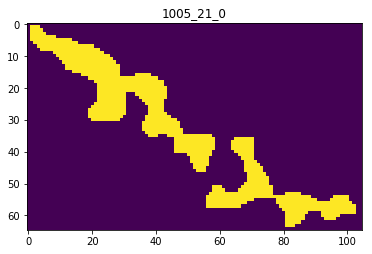

In [47]:
for k in norm_tree15:
    imshow(norm_tree15[k].root_node.mask)
    plt.title(k)

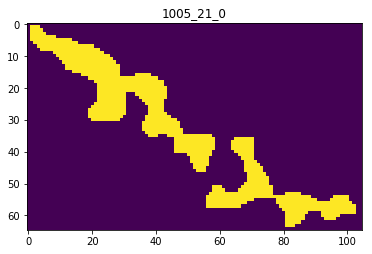

In [48]:
for k in bright_tree15:
    imshow(bright_tree15[k].root_node.mask)
    plt.title(k)

### BUT mask found injected filaments

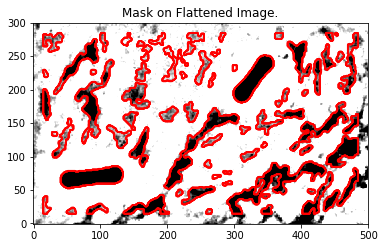

In [35]:
standard_width = 0.1 * u.pc
filfind1 = FilFinder2D(bright_usm30[9], header=pnarrow_header, distance=100.*u.pc, beamwidth=10.*u.arcmin)
filfind1.preprocess_image(flatten_percent=95)
filfind1.create_mask(border_masking=True, verbose=True,use_existing_mask=True, size_thresh=(standard_width * 2)**2)

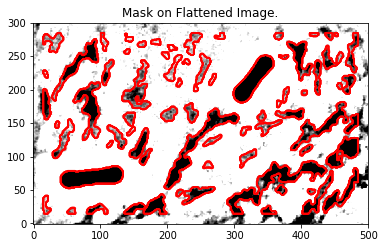

In [34]:
filfind = FilFinder2D(bright_usm30[10], header=pnarrow_header, distance=100.*u.pc, beamwidth=10.*u.arcmin)
filfind.preprocess_image(flatten_percent=95)
plt.title('Filament Detection at V=10')
filfind.create_mask(border_masking=True, verbose=True,use_existing_mask=True, size_thresh=(standard_width * 2)**2)

In [37]:
filfind_masks10, corners10 = filfind.create_mask(smooth_size = standard_width/2, adapt_thresh=standard_width*2, 
                         size_thresh= 8*(standard_width*2)**2, border_masking=False, output_mask_objs=True)

outputting mask objects


In [39]:
filfind_masks9, corners9 = filfind1.create_mask(smooth_size = standard_width/2, adapt_thresh=standard_width*2, 
                         size_thresh= 8*(standard_width*2)**2, border_masking=False, output_mask_objs=True)

outputting mask objects


In [41]:
node_dict9 = {}
for i in range(len(filfind_masks9)):
    mask_node=maskNode.MaskObjNode(filfind_masks9[i], corners9[i], 9)
    struct_util.add_node_to_dict(mask_node, node_dict9)
    
node_dict10 = {}
for i in range(len(filfind_masks10)):
    mask_node=maskNode.MaskObjNode(filfind_masks10[i], corners10[i], 10)
    struct_util.add_node_to_dict(mask_node, node_dict10)



In [42]:
all_dicts = {}
for i in [9,10]:
    all_dicts[i] = construct_filaments(bright_usm30[i], pnarrow_header, i)

outputting mask objects
outputting mask objects


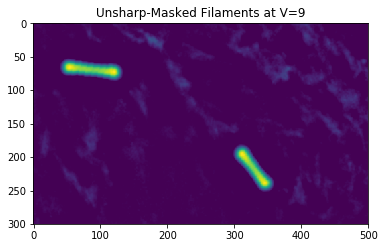

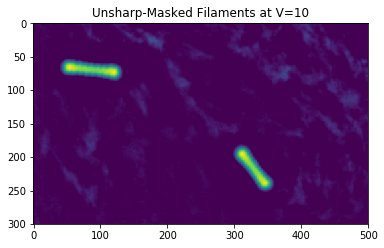

<Figure size 432x288 with 0 Axes>

In [45]:
a=bright_usm30[9:11]
for i in range(2):
    imshow(a[i])
    plt.title('Unsharp-Masked Filaments at V='+str(i+9))
    plt.figure()
    

In [54]:
### Now using another algorithm to find overlapping trees
trees_found = process_filaments(bright_usm30[9:11], pnarrow_header, wkernel=15, overlap=0.5, usm_return=False)

(300, 500)
(300, 500)
outputting mask objects
outputting mask objects


In [55]:
trees_found

{}

### No tree are found...

### But at least injected trees should be found

In [56]:
node_dict9

{'1101_0': <mask_obj_node.MaskObjNode instance at 0x1c301f6560>,
 '1125_0': <mask_obj_node.MaskObjNode instance at 0x1c2a51b2d8>,
 '1272_0': <mask_obj_node.MaskObjNode instance at 0x1c30ae0d88>,
 '1292_0': <mask_obj_node.MaskObjNode instance at 0x1c2a51b758>,
 '1794_0': <mask_obj_node.MaskObjNode instance at 0x1c301f6f80>,
 '1831_0': <mask_obj_node.MaskObjNode instance at 0x1c301f6b90>,
 '1981_0': <mask_obj_node.MaskObjNode instance at 0x1c30ae0200>,
 '2095_0': <mask_obj_node.MaskObjNode instance at 0x1c30ae0098>,
 '2190_0': <mask_obj_node.MaskObjNode instance at 0x1c2a51b680>,
 '3261_0': <mask_obj_node.MaskObjNode instance at 0x1c2a51b7a0>,
 '398_0': <mask_obj_node.MaskObjNode instance at 0x1c301f65f0>,
 '412_0': <mask_obj_node.MaskObjNode instance at 0x1c30b22878>,
 '443_0': <mask_obj_node.MaskObjNode instance at 0x1c30b22ab8>,
 '447_0': <mask_obj_node.MaskObjNode instance at 0x1c2a51b050>,
 '450_0': <mask_obj_node.MaskObjNode instance at 0x1c30b22248>,
 '470_0': <mask_obj_node.MaskO

/anaconda3/envs/py2-env/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


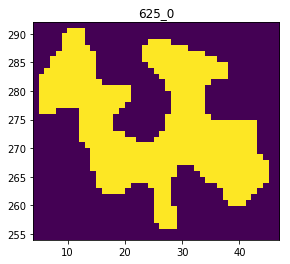

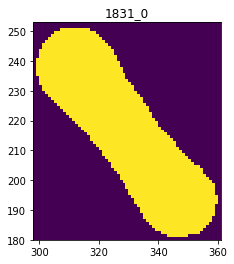

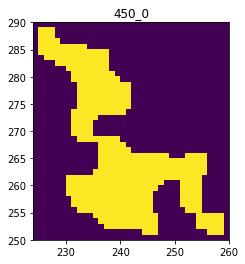

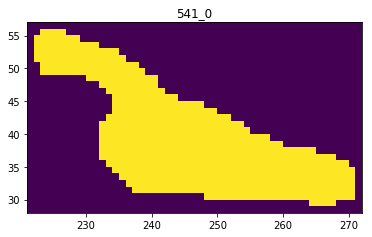

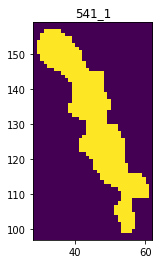

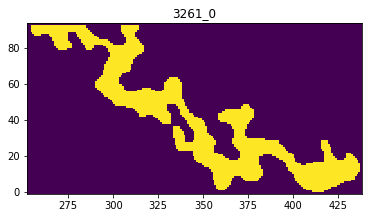

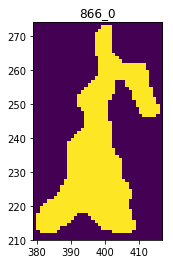

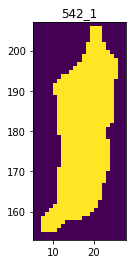

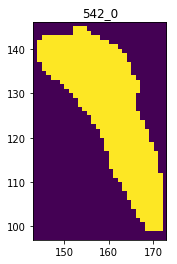

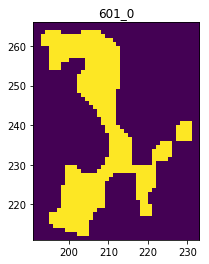

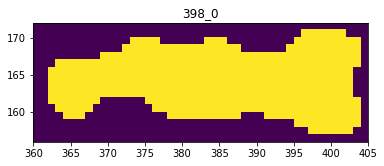

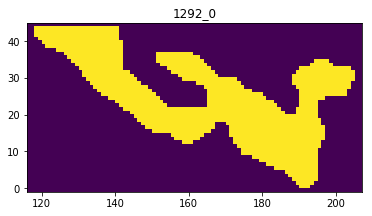

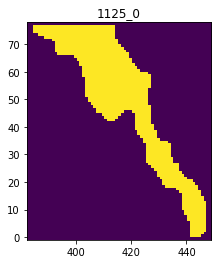

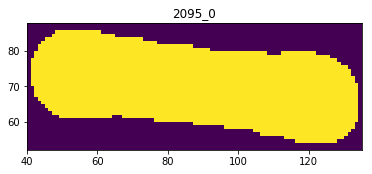

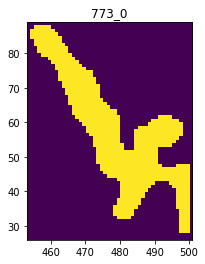

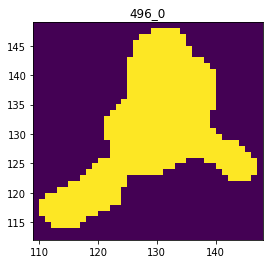

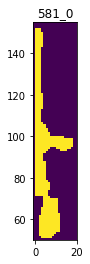

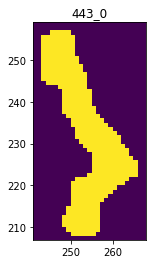

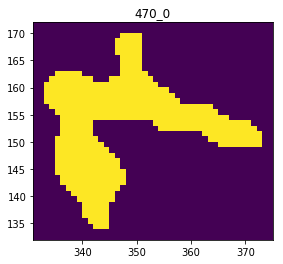

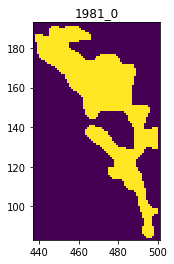

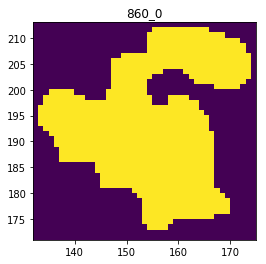

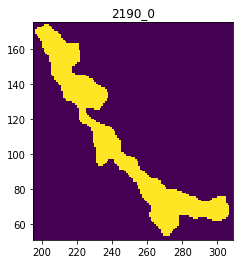

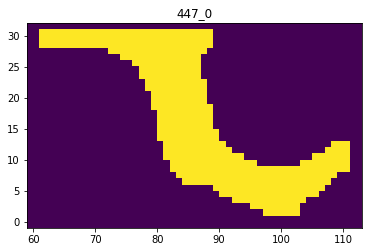

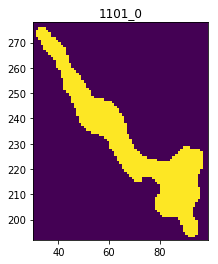

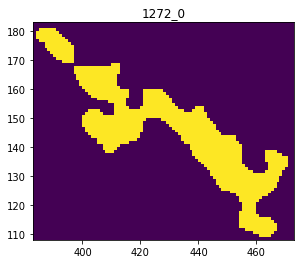

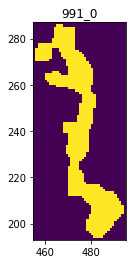

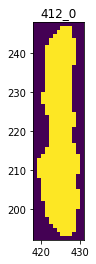

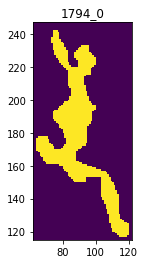

<Figure size 432x288 with 0 Axes>

In [58]:
### Node at V=9
for k in node_dict9:
    one_node = node_dict9[k]
    imshow(one_node.mask, extent=ordering_corners(one_node.corners_original))
    plt.title(k)
    plt.figure()

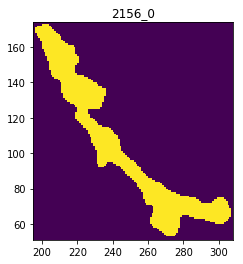

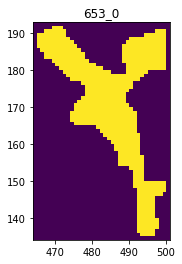

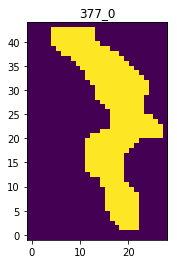

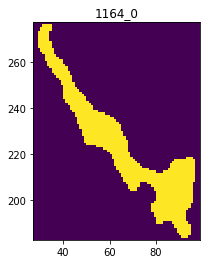

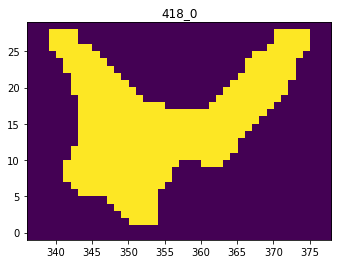

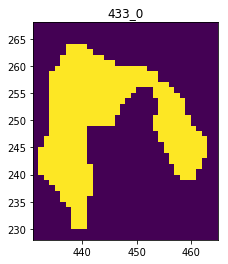

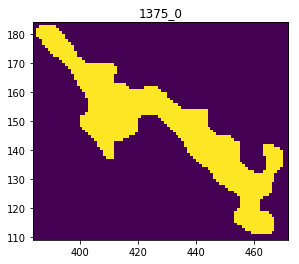

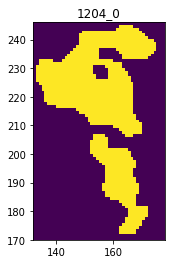

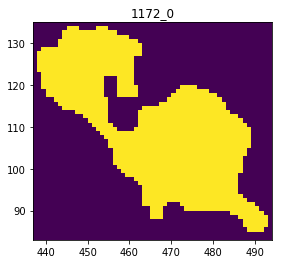

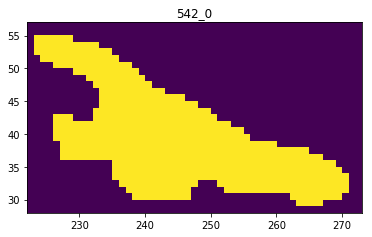

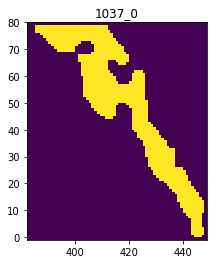

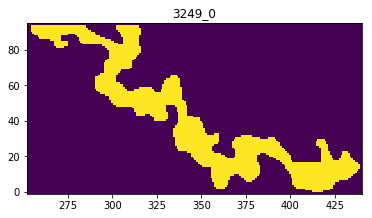

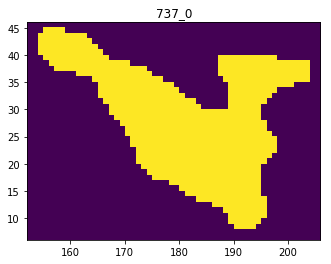

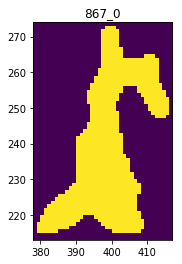

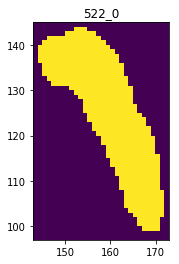

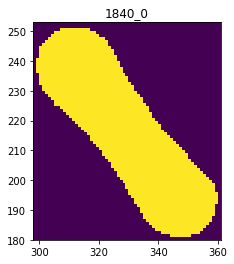

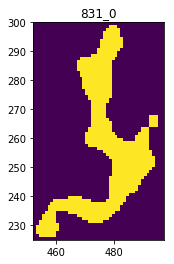

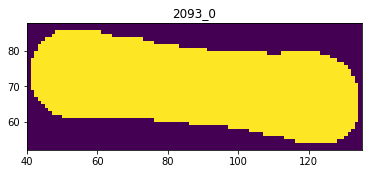

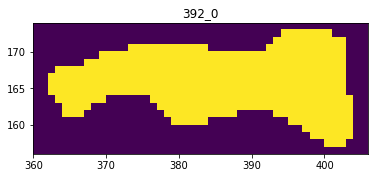

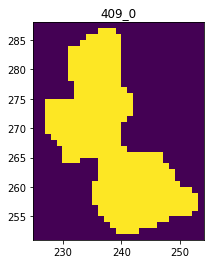

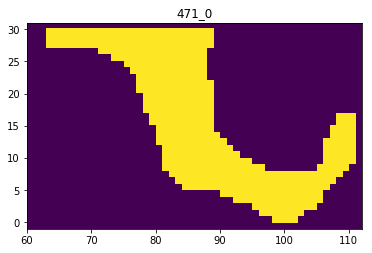

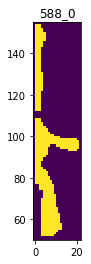

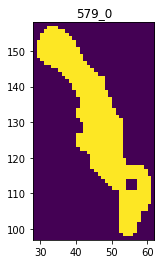

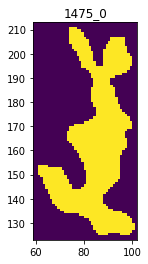

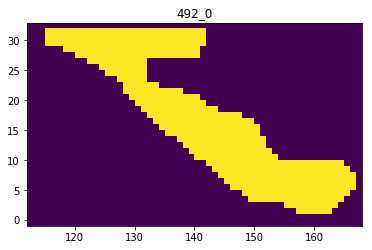

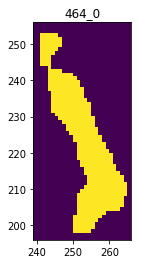

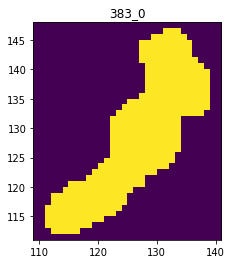

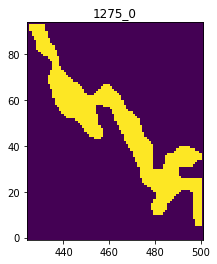

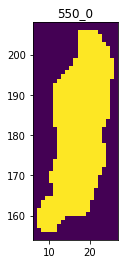

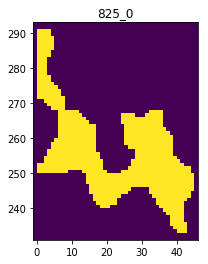

<Figure size 432x288 with 0 Axes>

In [60]:
### Node at V=10
for k in node_dict10:
    one_node = node_dict10[k]
    imshow(one_node.mask, extent=ordering_corners(one_node.corners_original))
    plt.title(k)
    plt.figure()

### TWO injected Filaments are here on Node

Text(0.5,1,'1840_0 at V=10')

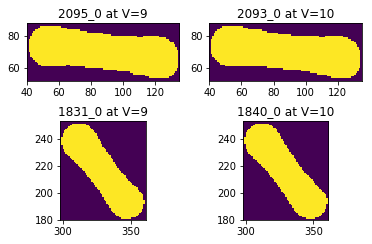

In [63]:
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(node_dict9['2095_0'].mask, extent=ordering_corners(node_dict9['2095_0'].corners_original))
ax[0,0].set_title('2095_0 at V=9')
 
ax[0,1].imshow(node_dict10['2093_0'].mask, extent=ordering_corners(node_dict10['2093_0'].corners_original))
ax[0,1].set_title('2093_0 at V=10')

ax[1,0].imshow(node_dict9['1831_0'].mask, extent=ordering_corners(node_dict9['1831_0'].corners_original))
ax[1,0].set_title('1831_0 at V=9')
 
ax[1,1].imshow(node_dict10['1840_0'].mask, extent=ordering_corners(node_dict10['1840_0'].corners_original))
ax[1,1].set_title('1840_0 at V=10')

### Mystery deepends as I get different result when I separate tree building part and run it: (Following is exactly same as find_tree function defined above)

In [70]:
trees = {}
connected_trees = set()

for i in [9,10]:
    current_node = all_dicts[i]
    sort_fil = tree_dict_util.struct_util.sorted_struct_dict_keys_by_area(current_node, 'node')
    #print (sort_fil)
    for j in range(len(sort_fil)):
        mode = current_node[sort_fil[j]]
        oldflag = tree_dict_util.match_and_add_node_onto_tree(mode, i, trees, 0.85, continuous_trees=connected_trees)
        #oldflag = tree_dict_util.match_and_add_node_onto_tree(mode, i, trees, 0.85)
        print (oldflag)
        if oldflag:
            print (sort_fil[j])
        else:
            new_tree = maskTree.newTreeFromNode(mode, verbose=False)
            struct_util.add_tree_to_dict(new_tree, trees)
    
    connected_trees = tree_dict_util.end_noncontinuous_trees(trees, i)
            
    

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
3249_0
True
2156_0
True
2093_0
True
1840_0
True
1475_0
True
1375_0
True
1275_0
True
1204_0
True
1172_0
True
1164_0
True
1037_0
True
867_0
False
True
825_0
True
737_0
False
True
588_0
True
579_0
True
550_0
True
542_0
True
522_0
False
True
471_0
False
False
False
False
True
392_0
True
383_0
False


In [71]:
trees

{'1101_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c2fc1f7a0>,
 '1125_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c2fc1f3b0>,
 '1272_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c2fd19b00>,
 '1292_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c30b7c680>,
 '1794_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c30b7c6c8>,
 '1831_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c30b7c200>,
 '1981_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c30b7ce18>,
 '2095_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c2fc29f38>,
 '2190_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c2fc29e60>,
 '3261_9_0': <cube_fil_finder.structs.mask_obj_node_tree.MaskObjNodeTree instance at 0x1c2fc29950>,


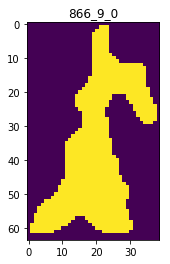

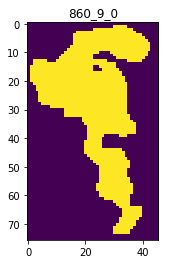

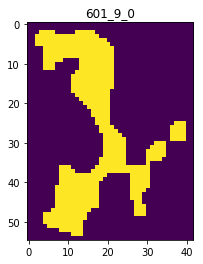

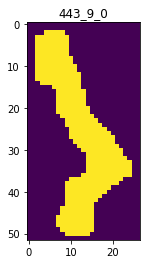

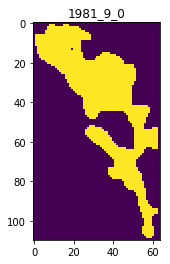

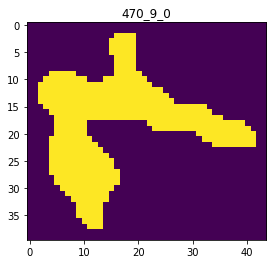

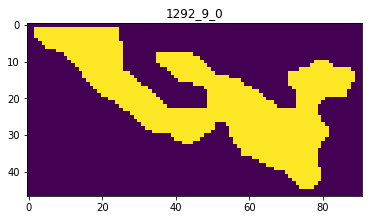

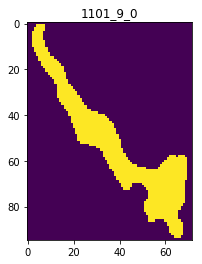

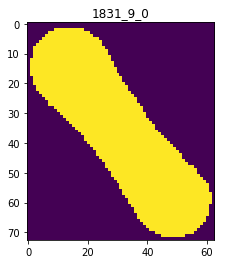

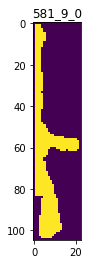

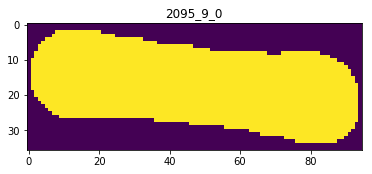

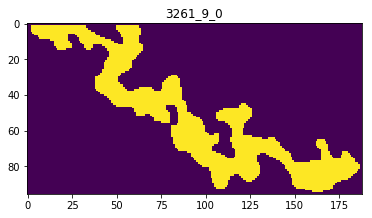

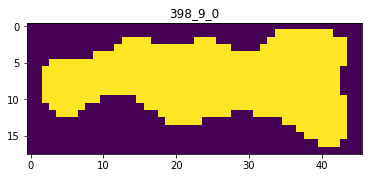

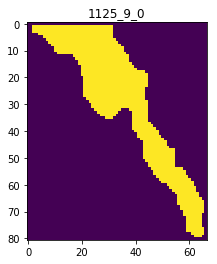

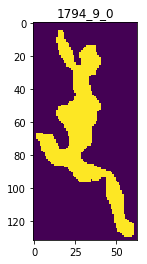

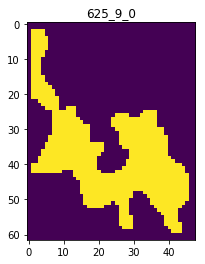

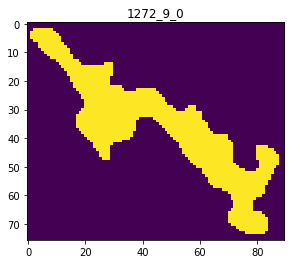

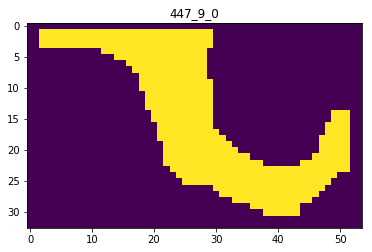

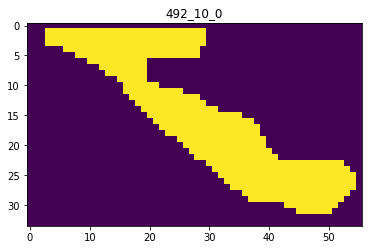

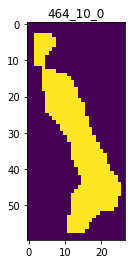

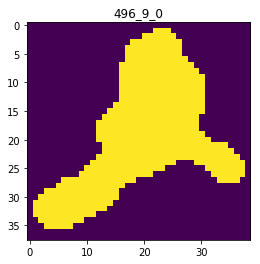

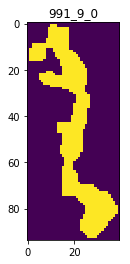

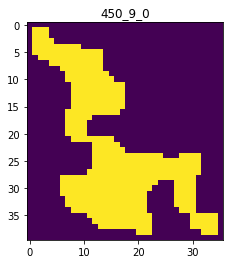

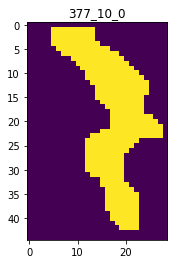

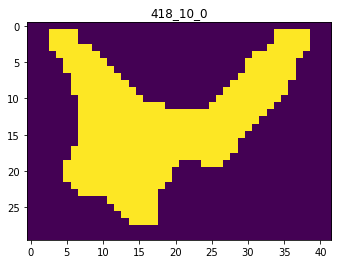

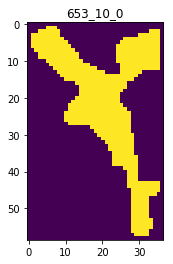

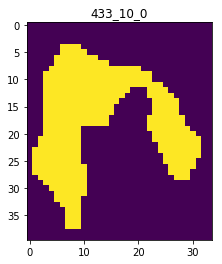

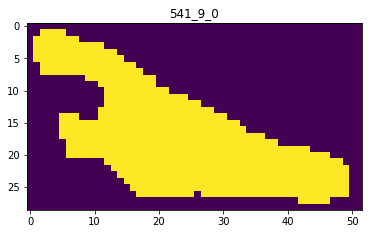

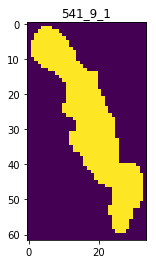

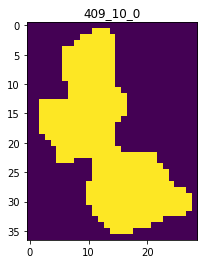

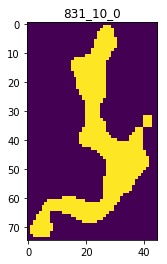

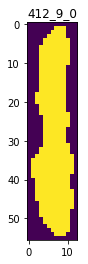

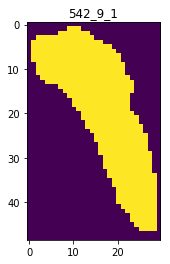

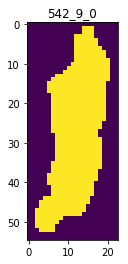

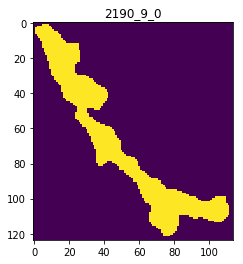

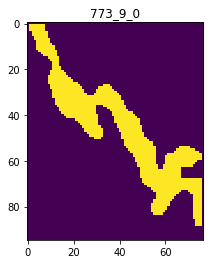

<Figure size 432x288 with 0 Axes>

In [78]:
for k in trees:
    imshow(trees[k].root_node.mask)
    plt.title(k)
    plt.figure()

In [84]:
inj1=trees['1831_9_0']
inj2 = trees['2095_9_0']

In [85]:
print (inj1.getTreeVelocityRange())
print (inj2.getTreeVelocityRange())


[ 9 10]
[ 9 10]


### Injected filaments are recovered in this case

### My guess is there is some bug in connecting trees

In [67]:
def compare_two_pop(ref, exp, thresh=5):
    """
    Compare two populations and get the different pop from experimental one
    """
    inject = exp.copy()
    
    for k in exp:
        one = exp[k]
        for j in ref:
            two = ref[j]
            try:
                if compare_corners(one, two, thresh):
                    inject.pop(k)
            except KeyError:
                pass
            
    return inject
        
def compare_corners(one, two, thresh=5):
    """
    Compare corners
    """
    corner1 = np.array(one.root_node.corners_original)
    corner2 = np.array(two.root_node.corners_original)
    summed = np.sum(np.abs(corner1-corner2))
    #print (summed)
    if summed < thresh:
        return True ## same population
    else:
        return False
            
                
        

[[168, 177], [256, 221]]
[[167, 177], [256, 221]]


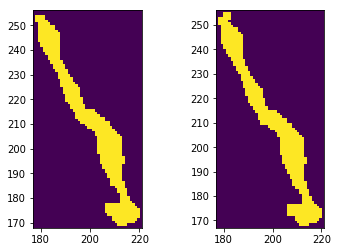

In [187]:
key1='457_19_1'
key2='465_19_0'

samp1=bright_tree15
samp2=ref15

fig, ax = plt.subplots(1,2)
tree1 = samp1[key1]
ax[0].imshow(tree1.root_node.mask, extent=gt.corner_extent(tree1.root_node))
print (tree1.root_node.corners_original)
tree2 = samp2[key2]
ax[1].imshow(tree2.root_node.mask, extent=gt.corner_extent(tree2.root_node))
print (tree2.root_node.corners_original)